<a href="https://colab.research.google.com/github/shouryamundra/state-driver-detection/blob/main/state_driver_detection_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a name="0">State Farm Distracted Driver Detection</a>
## A Computer Vision Problem.
### The competition page from [this](https://www.kaggle.com/competitions/state-farm-distracted-driver-detection) link.


### Table of Contents of the notebook:

1. <a href="#1">**Libraries**</a>
2. <a href="#2">**Display Excel File**</a>
3. <a href="#3">**Split train data to train & validation**</a>
4. <a href="#4">**Display some Images**</a>
5. <a href='#5'>**Dense Layer**</a>
6. <a href='#6'>**CNN model**</a>
7. <a href="#7">**Data Augentation**</a>
8. <a href="#8">**Frozen model**</a>
9. <a href="#9">**Fine Tuning**</a>
10. <a href="#10">**Testing**</a>
11. <a href="#11">**Group names**</a>

# 1. <a name="1">**Libraries**</a>

In [ ]:
!pip install --upgrade tensorflow==2.12.0

In [2]:
!pip install split-folders

In [3]:
! pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shouryamundra","key":"2e7c06ff474cdd7ae464fe3f38c83b30"}'}

In [5]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'state-farm-distracted-driver-detection'

100% 3.99G/4.00G [00:48<00:00, 156MB/s]
100% 4.00G/4.00G [00:48<00:00, 89.0MB/s]


In [ ]:
!unzip state-farm-distracted-driver-detection.zip

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

from getpass import getpass
import os
import cv2, glob

import splitfolders

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.python.keras as keras

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import VGG16, VGG19, ResNet50, MobileNet
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input

from tensorflow.keras.applications.imagenet_utils import decode_predictions

from tensorflow.keras.models import load_model

In [9]:
plt.style.use('dark_background')

In [10]:
keras.__version__

'2.6.0'

# 2. <a name="2">**Display Excel File**</a>

In [11]:
df = pd.read_csv("/content/driver_imgs_list.csv")
df.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [12]:
df.shape

(22424, 3)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


### 3. <a name="3">**Split train data to train & validation**</a>

In [14]:
data_dir = '/content/imgs/train'
splitfolders.ratio(data_dir, output="dataa",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 22424 files [00:04, 5188.27 files/s]


# 4. <a name="4">**Display some Images**</a>

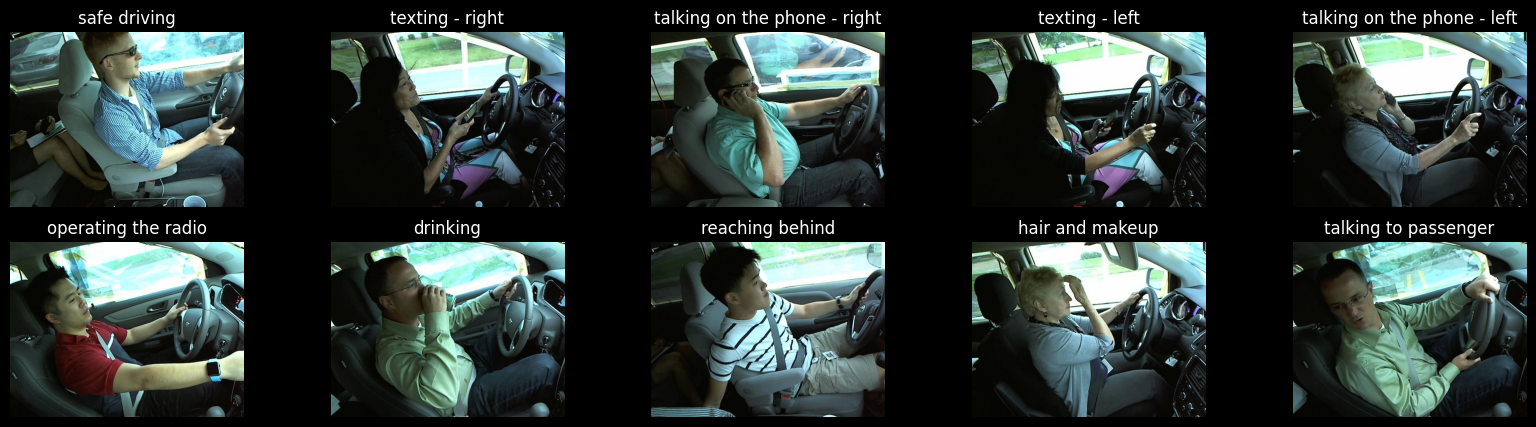

In [15]:
state = ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left',
         'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger', 'UNKNOWN']

def Display(path, Class=None):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if Class == None:
        plt.figure()
        plt.title(state[10])
        plt.imshow(img)
        plt.axis("off")
        # print(img.shape)
    else:
        plt.subplot(2, 5, Class+1)
        plt.title(state[Class])
        plt.imshow(img)
        plt.axis("off")

plt.figure(figsize=(20, 5))
Display("/content/imgs/train/c0/img_100026.jpg", 0)
Display("/content/imgs/train/c1/img_100021.jpg", 1)
Display("/content/imgs/train/c2/img_100029.jpg", 2)
Display("/content/imgs/train/c3/img_100006.jpg", 3)
Display("/content/imgs/train/c4/img_100225.jpg", 4)
Display("/content/imgs/train/c5/img_10000.jpg", 5)
Display("/content/imgs/train/c6/img_100036.jpg", 6)
Display("/content/imgs/train/c7/img_100057.jpg", 7)
Display("/content/imgs/train/c8/img_100015.jpg", 8)
Display("/content/imgs/train/c9/img_100090.jpg", 9)

# 5. <a name="5">**Dense Layer**</a>

In [ ]:
dense_train_gen = ImageDataGenerator(rescale=1./255)
dense_train = dense_train_gen.flow_from_directory('/content/dataa/train/', batch_size=128, target_size= (256, 256))

dense_val_gen = ImageDataGenerator(rescale=1./255)
dense_val = dense_val_gen.flow_from_directory('/content/dataa/val/', batch_size=128, target_size= (256, 256))

Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


In [ ]:
model_dense = models.Sequential()
model_dense.add(Flatten(input_shape=(256, 256, 3)))
model_dense.add(Dense(512, activation='relu'))
model_dense.add(Dense(256, activation='relu'))
model_dense.add(Dense(128, activation='relu'))
model_dense.add(Dense(10, activation='softmax'))
model_dense.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
model_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 512)               100663808 
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 100,829,322
Trainable params: 100,829,322
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_dense = model_dense.fit(dense_train ,epochs=10,validation_data=dense_val)

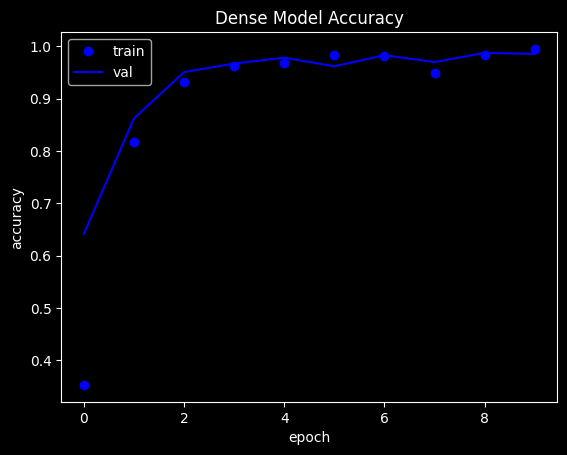

In [ ]:
plt.plot(history_dense.history['accuracy'], 'bo')
plt.plot(history_dense.history['val_accuracy'], 'b')
plt.title('Dense Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_dense.history['loss'], 'bo')
plt.plot(history_dense.history['val_loss'], 'b')
plt.title('Dense Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

NameError: ignored

In [ ]:
model_dense.save('/content/dense_model.h5')

In [ ]:
acc1=history_dense.history['accuracy'][-1]
vacc1=history_dense.history['val_accuracy'][-1]
print(acc1, vacc1)

0.9953161478042603 0.9857460856437683


# 6. <a name="6">**CNN model**</a>

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255)
train = train_gen.flow_from_directory('/content/dataa/train', batch_size=64, target_size= (256, 256))

val_gen = ImageDataGenerator(rescale=1./255)
val = val_gen.flow_from_directory('/content/dataa/val', batch_size=64, target_size= (256, 256))

Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


In [ ]:
model_CNN = models.Sequential()
model_CNN.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_CNN.add(MaxPooling2D((2, 2)))


model_CNN.add(Conv2D(64, (3, 3), activation='relu'))
model_CNN.add(MaxPooling2D((2, 2)))

model_CNN.add(Conv2D(128, (3, 3), activation='relu'))
model_CNN.add(MaxPooling2D((2, 2)))

model_CNN.add(Flatten())
model_CNN.add(Dense(128, activation='relu'))



model_CNN.add(Dense(10, activation='softmax'))


model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)     

In [ ]:
model_CNN.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])

In [ ]:
from IPython.testing import test
history_CNN=model_CNN.fit(train ,epochs=20, batch_size=64,validation_data=val)

Epoch 1/20
281/281 [==============================] - 104s 319ms/step - loss: 0.5208 - acc: 0.8313 - val_loss: 0.0771 - val_acc: 0.9775
Epoch 2/20
281/281 [==============================] - 88s 314ms/step - loss: 0.0401 - acc: 0.9894 - val_loss: 0.0474 - val_acc: 0.9846
Epoch 3/20
281/281 [==============================] - 94s 333ms/step - loss: 0.0173 - acc: 0.9951 - val_loss: 0.0677 - val_acc: 0.9820
Epoch 4/20
281/281 [==============================] - 91s 324ms/step - loss: 0.0154 - acc: 0.9949 - val_loss: 0.0399 - val_acc: 0.9875
Epoch 5/20
281/281 [==============================] - 88s 314ms/step - loss: 0.0106 - acc: 0.9970 - val_loss: 0.0803 - val_acc: 0.9762
Epoch 6/20
281/281 [==============================] - 87s 308ms/step - loss: 0.0134 - acc: 0.9962 - val_loss: 0.0256 - val_acc: 0.9929
Epoch 7/20
281/281 [==============================] - 88s 313ms/step - loss: 0.0044 - acc: 0.9988 - val_loss: 0.0471 - val_acc: 0.9875
Epoch 8/20
281/281 [==============================] - 

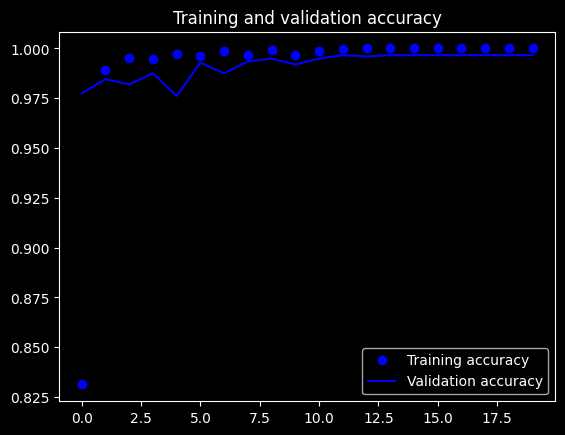

In [ ]:
acc = history_CNN.history['acc']
val_acc = history_CNN.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

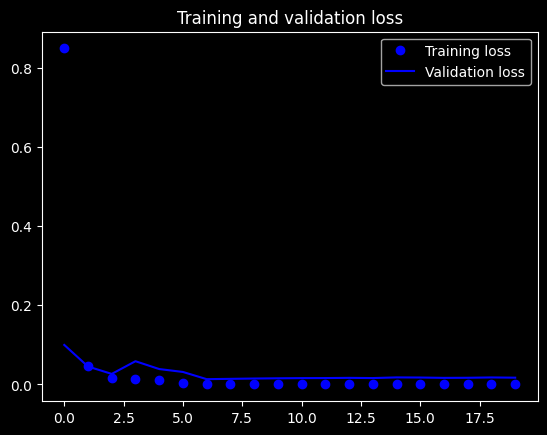

In [ ]:
loss = history_CNN.history['loss']
val_loss = history_CNN.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_CNN.save('/content/CNN_model.h5')

# 7. <a name="7">**Data Augmentation**</a>

## Preprocessing

In [16]:
batch_size = 32
datagen = ImageDataGenerator(rescale = 1/255,
                            zoom_range=0.05,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            fill_mode="nearest")


train = datagen.flow_from_directory('/content/dataa/train', batch_size=batch_size, target_size = (256, 256))

val_gen = ImageDataGenerator(rescale = 1/255)
val = val_gen.flow_from_directory('/content/dataa/val', batch_size=batch_size, target_size = (256, 256))

Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


In [17]:
for data_batch, labels_batch in train:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 256, 256, 3)
labels batch shape: (32, 10)


## Baseline Model

In [ ]:
from keras import models
from keras import layers
from tensorflow.keras.layers import Dropout

model_DA = models.Sequential()
model_DA.add(layers.Conv2D(32,(3,3), activation='relu', name='Layer_1', input_shape=(256,256, 3)))
model_DA.add(layers.MaxPooling2D((2, 2)))
model_DA.add(layers.Conv2D(128,(3,3), activation='relu', name='Layer_2'))
model_DA.add(layers.MaxPooling2D((2, 2)))
model_DA.add(layers.Conv2D(128,(3,3), activation='relu', name='Layer_3'))
model_DA.add(layers.MaxPooling2D((2, 2)))
model_DA.add(layers.Conv2D(64,(3,3), activation='relu', name='Layer_4'))
model_DA.add(layers.MaxPooling2D((2, 2)))
model_DA.add(layers.Flatten())
model_DA.add(layers.Dense(512, activation='relu'))
model_DA.add(layers.Dropout(0.4))
model_DA.add(layers.Dense(10, activation='softmax'))

In [ ]:
model_DA.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_1 (Conv2D)            (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 Layer_2 (Conv2D)            (None, 125, 125, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 Layer_3 (Conv2D)            (None, 60, 60, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)     

In [ ]:
model_DA.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
history_DA = model_DA.fit(
      train,
      epochs=20,
      steps_per_epoch = 150,
      validation_data=val,
      verbose=2,
      validation_steps=50)

Epoch 1/20
150/150 - 88s - loss: 1.9629 - accuracy: 0.2892 - val_loss: 1.0358 - val_accuracy: 0.6750 - 88s/epoch - 586ms/step
Epoch 2/20
150/150 - 80s - loss: 1.0146 - accuracy: 0.6604 - val_loss: 0.4587 - val_accuracy: 0.8700 - 80s/epoch - 536ms/step
Epoch 3/20
150/150 - 84s - loss: 0.6080 - accuracy: 0.8048 - val_loss: 0.2307 - val_accuracy: 0.9375 - 84s/epoch - 558ms/step
Epoch 4/20
150/150 - 84s - loss: 0.4445 - accuracy: 0.8625 - val_loss: 0.1807 - val_accuracy: 0.9400 - 84s/epoch - 560ms/step
Epoch 5/20
150/150 - 81s - loss: 0.3616 - accuracy: 0.8846 - val_loss: 0.1428 - val_accuracy: 0.9588 - 81s/epoch - 540ms/step
Epoch 6/20
150/150 - 79s - loss: 0.3032 - accuracy: 0.9032 - val_loss: 0.1250 - val_accuracy: 0.9631 - 79s/epoch - 525ms/step
Epoch 7/20
150/150 - 80s - loss: 0.2703 - accuracy: 0.9151 - val_loss: 0.1016 - val_accuracy: 0.9719 - 80s/epoch - 533ms/step
Epoch 8/20
150/150 - 80s - loss: 0.2305 - accuracy: 0.9340 - val_loss: 0.0903 - val_accuracy: 0.9750 - 80s/epoch - 533

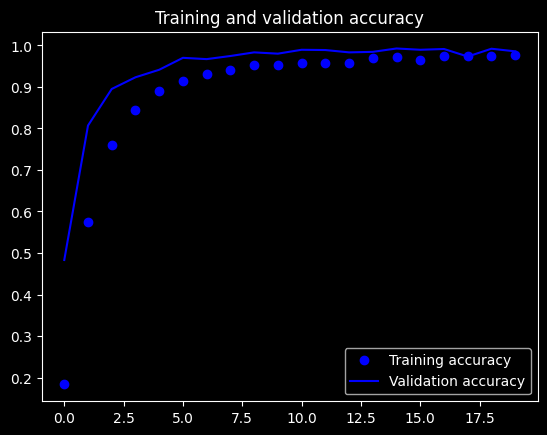

In [ ]:
acc = history_DA.history['accuracy']
val_acc = history_DA.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

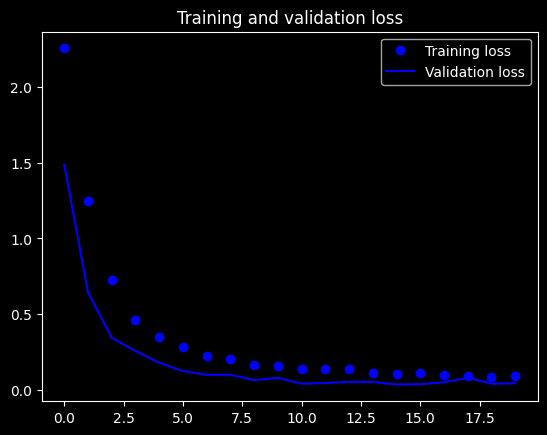

In [ ]:
loss = history_DA.history['loss']
val_loss = history_DA.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_DA.save("/content/Data_Augmentation_model.h5")

# 8. <a name="8">**Frozen model**</a>

In [18]:
batch_size = 32
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                            zoom_range=0.05,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            fill_mode="nearest")


train = datagen.flow_from_directory('/content/dataa/train', batch_size=batch_size, target_size = (256, 256))

val_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
val = val_gen.flow_from_directory('/content/dataa/val', batch_size=batch_size, target_size = (256, 256))

Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


## Build NN

In [ ]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

# conv_base = ResNet50(weights='imagenet',
#                   include_top=False,
#                   input_shape=(256, 256, 3))

# conv_base = MobileNet(weights='imagenet',
#                   include_top=False,
#                   input_shape=(256, 256, 3))

conv_base.summary()

In [20]:
model_DL = models.Sequential()
model_DL.add(conv_base)
model_DL.add(layers.Flatten())
model_DL.add(layers.Dense(512, activation='relu'))
model_DL.add(layers.Dropout(0.35))
model_DL.add(layers.Dense(128, activation='relu'))
model_DL.add(layers.Dropout(0.35))
model_DL.add(layers.Dense(32, activation='relu'))
model_DL.add(layers.Dense(10, activation='softmax'))

model_DL.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4

In [21]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model_DL.trainable_weights))

This is the number of trainable weights before freezing the conv base: 34


In [22]:
conv_base.trainable = False

In [23]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model_DL.trainable_weights))

This is the number of trainable weights after freezing the conv base: 8


In [24]:
model_DL.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4

In [25]:
model_DL.compile(optimizer = optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint('model_DL_s1_vgg16.h5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# history_DL = model_DL.fit(train,
#                     epochs=20,
#                     steps_per_epoch = 150,
#                     validation_data=val,
#                     verbose=1)

history_DL = model_DL.fit(train,
                    epochs=20,
                    callbacks=[checkpointer, earlystopper],
                    steps_per_epoch = 150,
                    validation_data=val,
                    verbose=1)

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 5.4443 - accuracy: 0.1969
Epoch 00001: val_loss improved from inf to 1.46934, saving model to model_DL_s1_vgg16.h5
150/150 [==============================] - 129s 738ms/step - loss: 5.4443 - accuracy: 0.1969 - val_loss: 1.4693 - val_accuracy: 0.5114
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 2.3696 - accuracy: 0.3379
Epoch 00002: val_loss improved from 1.46934 to 0.99806, saving model to model_DL_s1_vgg16.h5
150/150 [==============================] - 108s 715ms/step - loss: 2.3696 - accuracy: 0.3379 - val_loss: 0.9981 - val_accuracy: 0.6764
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 1.7054 - accuracy: 0.4769
Epoch 00003: val_loss improved from 0.99806 to 0.70425, saving model to model_DL_s1_vgg16.h5
150/150 [==============================] - 107s 713ms/step - loss: 1.7054 - accuracy: 0.4769 - val_loss: 0.7042 - val_accuracy: 0.7655
Epoch 4/20
150/150 [============

In [26]:
train_acc, train_loss = model_DL.evaluate(train)

561/561 [==============================] - 308s 549ms/step - loss: 0.0457 - accuracy: 0.9867


In [27]:
val_acc, val_loss = model_DL.evaluate(val)

141/141 [==============================] - 25s 173ms/step - loss: 0.0559 - accuracy: 0.9851


93.52083206176758
98.5077977180481


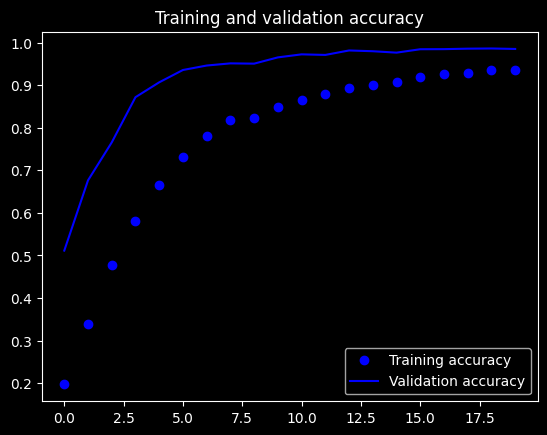

In [28]:
acc = history_DL.history['accuracy']
val_acc = history_DL.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

print(acc[-1]*100)
print(val_acc[-1]*100)

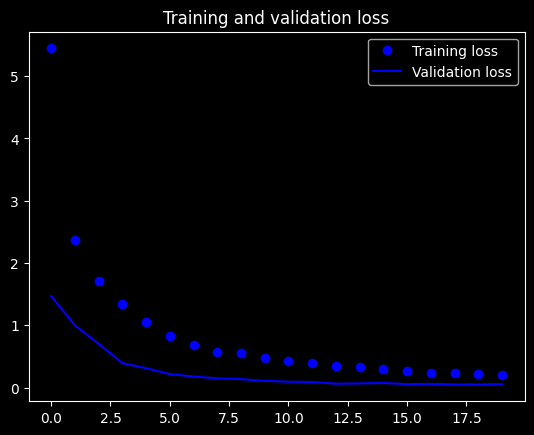

In [29]:
loss = history_DL.history['loss']
val_loss = history_DL.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
model_DL.save('/content/driver_detection_Frozen_model-epochs 20 vgg16.h5')
print("Saved model to content")

Saved model to content


# 9. <a name="9">**Fine Tuning**</a>

In [ ]:
conv_base.summary()

In [32]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
conv_base.summary()

In [ ]:
# tf.keras.utils.plot_model(conv_base, to_file='model_DL.png', show_shapes=True)

In [35]:
# model_copy= keras.models.clone_model(model_DL)
# # model_copy = keras.models.load_model('/content/driver_detection_Frozen_model.h5')
# model_copy.build((None, 150, 150, 3))
model_DL.compile(optimizer = optimizers.Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
# model_copy.set_weights(model_DL.get_weights())

In [ ]:
model_DL.summary()

In [37]:
model_DL.compile(optimizer = optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
checkpointer = keras.callbacks.ModelCheckpoint('model_FT_s1.h5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history_FT = model_DL.fit(
      train,
      steps_per_epoch=100,                 #train.n//train.batch_size,
      epochs=50,
      validation_data=val,
      validation_steps=50,                 #val.n//val.batch_size)
      verbose=1,
      # callbacks=[checkpointer, earlystopper])
)

Epoch 1/50
100/100 [==============================] - 67s 639ms/step - loss: 0.2591 - accuracy: 0.9375 - val_loss: 0.0424 - val_accuracy: 0.9869
Epoch 2/50
100/100 [==============================] - 64s 636ms/step - loss: 0.2671 - accuracy: 0.9272 - val_loss: 0.0701 - val_accuracy: 0.9806
Epoch 3/50
100/100 [==============================] - 64s 637ms/step - loss: 0.2148 - accuracy: 0.9431 - val_loss: 0.0361 - val_accuracy: 0.9912
Epoch 4/50
100/100 [==============================] - 64s 639ms/step - loss: 0.2183 - accuracy: 0.9400 - val_loss: 0.0514 - val_accuracy: 0.9900
Epoch 5/50
100/100 [==============================] - 64s 638ms/step - loss: 0.2639 - accuracy: 0.9312 - val_loss: 0.0397 - val_accuracy: 0.9887
Epoch 6/50
100/100 [==============================] - 63s 630ms/step - loss: 0.2251 - accuracy: 0.9362 - val_loss: 0.0429 - val_accuracy: 0.9887
Epoch 7/50
100/100 [==============================] - 66s 654ms/step - loss: 0.2070 - accuracy: 0.9419 - val_loss: 0.0292 - val_ac

In [39]:
train_acc_FT, train_loss_FT = model_DL.evaluate(train)

561/561 [==============================] - 303s 539ms/step - loss: 0.0092 - accuracy: 0.9975


In [40]:
val_acc_FT, val_loss_FT = model_DL.evaluate(val)

141/141 [==============================] - 26s 181ms/step - loss: 0.0185 - accuracy: 0.9953


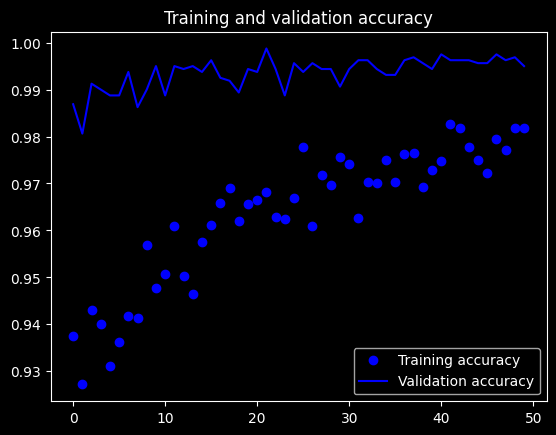

In [41]:
acc = history_FT.history['accuracy']
val_acc = history_FT.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

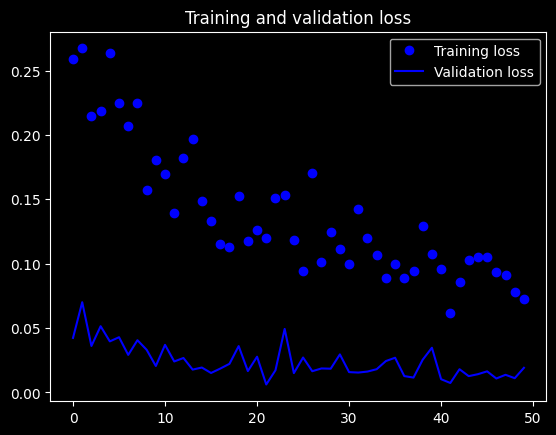

In [42]:
loss = history_FT.history['loss']
val_loss = history_FT.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Smoothing

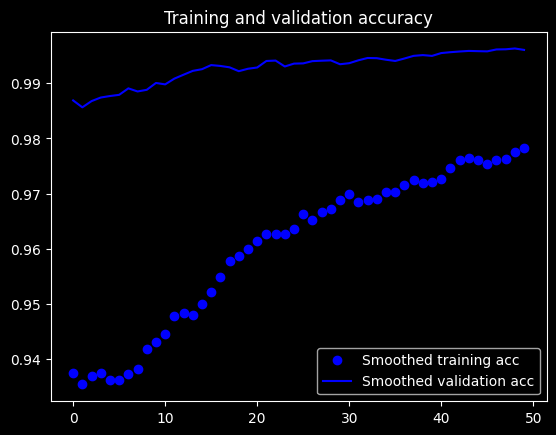

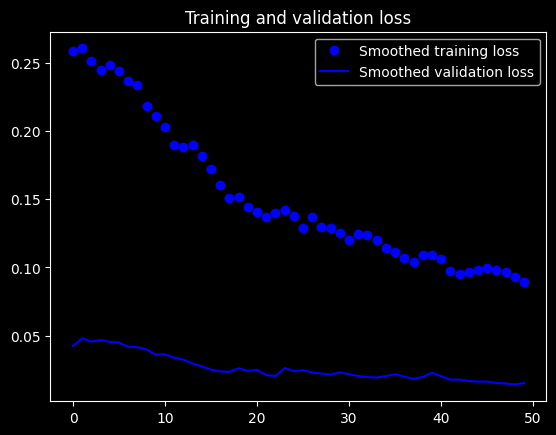

In [43]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [46]:
model_DL.save('/content/driver_detection_Fine_Tuning_model2 Vgg16 50epochs.h5')
print("Saved model to content")

Saved model to content


In [47]:
# # dense
# acc1=history_dense.history['accuracy'][-1]
# vacc1=history_dense.history['val_accuracy'][-1]
# loss1=history_dense.history['loss'][-2]
# vloss1=history_dense.history['val_loss'][-2]


# # CNN
# acc2=history_CNN.history['acc'][-1]
# vacc2=history_CNN.history['val_acc'][-1]
# loss2=history_CNN.history['loss'][-2]
# vloss2=history_CNN.history['val_loss'][-2]

#  # Data Augmentation
# acc3=history_DA.history['accuracy'][-1]
# vacc3=history_DA.history['val_accuracy'][-1]
# loss3=history_DA.history['loss'][-2]
# vloss3=history_DA.history['val_loss'][-2]

# VGG16
acc4=history_DL.history['accuracy'][-1]
vacc4=history_DL.history['val_accuracy'][-1]
loss4=history_DL.history['loss'][-2]
vloss4=history_DL.history['val_loss'][-2]

# VGG16
acc5=history_FT.history['accuracy'][-1]
vacc5=history_FT.history['val_accuracy'][-1]
loss5=history_FT.history['loss'][-2]
vloss5=history_FT.history['val_loss'][-2]

In [48]:
# results = pd.DataFrame([["Dense model",acc1*100,vacc1*100,loss1,vloss1],
#                        ["CNN",acc2*100,vacc2*100,loss2,vloss2],
#                        ["CNN_data_augmentation",acc3*100,vacc3*100,loss3,vloss3],
#                        ["Transfer Learning model",acc4*100,vacc4*100,loss4,vloss4],
#                        ["Transfer Learning model_FT",acc5*100,vacc5*100,loss5,vloss5]],
#                        columns = ["Model","Training Accuracy %","Validation Accuracy %", 'Loss', 'Validation Loss'])

results = pd.DataFrame([["Transfer Learning model",acc4*100,vacc4*100,loss4,vloss4],
                        ["Transfer Learning model_FT",acc5*100,vacc5*100,loss5,vloss5]],
                       columns = ["Model","Training Accuracy %","Validation Accuracy %", 'Loss', 'Validation Loss'])
results

Model  Training Accuracy %  Validation Accuracy %  \
0     Transfer Learning model            93.520832              98.507798   
1  Transfer Learning model_FT            98.187500              99.500000   

       Loss  Validation Loss  
0  0.226637         0.050737  
1  0.078306         0.011086

# 10. <a name="10">**Testing on AUC (Domain Adaptation)**</a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [56]:
df_auc_test = pd.read_csv('gdrive/MyDrive/auc.distracted.driver.test.csv')

get the dataset for testing for the model to predict

In [62]:
model_test_base = load_model('driver_detection_Fine_Tuning_model2 Vgg16 50epochs.h5')
model_test_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4

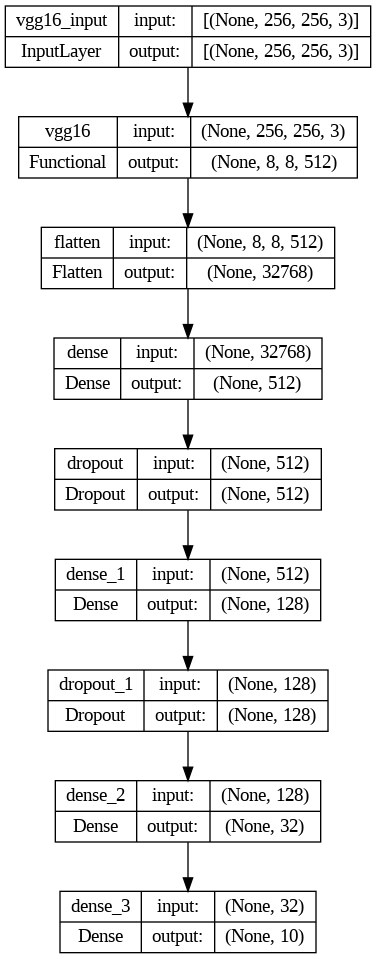

In [63]:
tf.keras.utils.plot_model(model_test_base, to_file='model_Vgg16 50epochs.png', show_shapes=True)

replace and retrain the top layers:

add a new fully connected layer that matches the number of classes  
freeze the layers of the pretrained model
train the new layers on your dataset

In [ ]:
model_test_auc = models.Sequential()
model_test_auc.add(model_test_base)
model_test_auc.add(layers.Flatten())
model_test_auc.add(layers.Dense(512, activation='relu'))
model_test_auc.add(layers.Dropout(0.35))
model_test_auc.add(layers.Dense(128, activation='relu'))
model_test_auc.add(layers.Dropout(0.35))
model_test_auc.add(layers.Dense(32, activation='relu'))
model_test_auc.add(layers.Dense(10, activation='softmax'))

model_test_auc.summary()

In [81]:
model_test_auc.trainable = False
len(model_DL.trainable_weights)

In [54]:
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D

# # add a global spatial average pooling layer
# x = model.output
# x = GlobalAveragePooling2D()(x)
# # add a fully-connected layer
# x = Dense(1024, activation='relu')(x)
# # and a logistic layer with the number of classes in the new dataset
# predictions = Dense(num_classes, activation='softmax')(x)

# # this is the model we will train
# model = Model(inputs=model.input, outputs=predictions)

# # first: train only the top layers (which were randomly initialized)
# for layer in model.layers[:-4]:
#     layer.trainable = False

# # compile the model (should be done *after* setting layers to non-trainable)
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# # train the model on the new data for a few epochs
# model.fit(...)

# 10. <a name="10">**Testing**</a>

## Displaying some test images

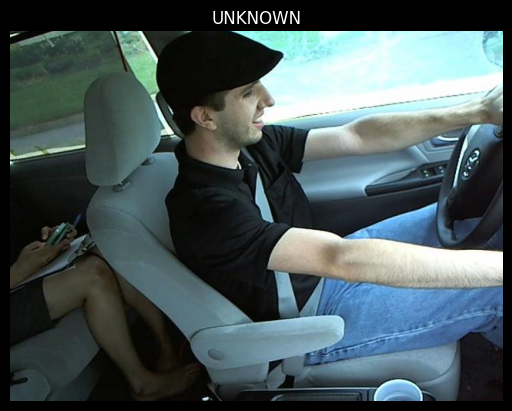

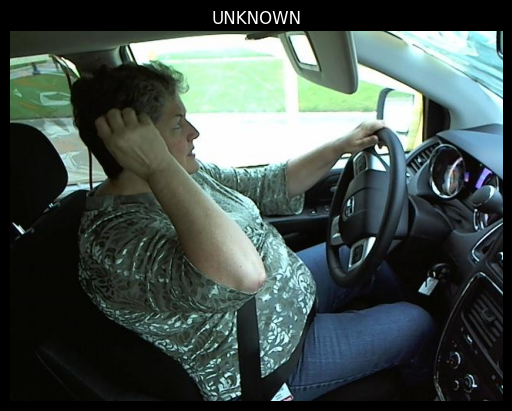

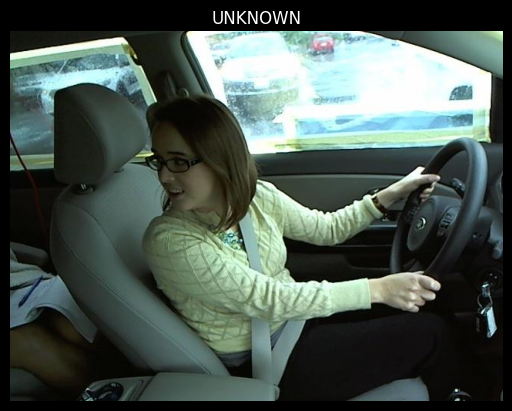

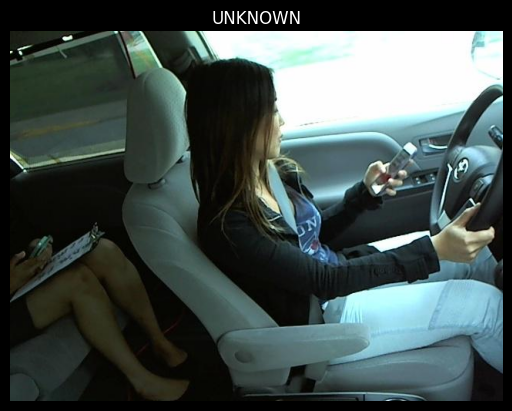

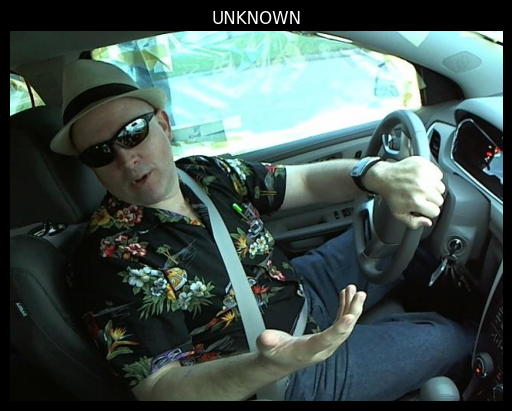

In [64]:
Display("/content/imgs/test/img_10.jpg")
Display("/content/imgs/test/img_100008.jpg")
Display("/content/imgs/test/img_100049.jpg")
Display("/content/imgs/test/img_100163.jpg")
Display("/content/imgs/test/img_100300.jpg")

## Load Test Data

In [65]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test = test_datagen.flow_from_directory('/content/imgs/.',
                                                  classes=['test'],
                                                  target_size=(256, 256),
                                                  batch_size = 20,
                                                  class_mode = None,
                                                  shuffle = False)

Found 79726 images belonging to 1 classes.


## Prediction

In [66]:
# # Load Model
# model = load_model('/kaggle/working/driver_detection_Fine_Tuning_model.h5')
# model.summary()  # As a reminder.

In [67]:
# Predict
# Predict = model_DL.predict(test)
Predict = model_test_base.predict(test)

3987/3987 [==============================] - 586s 146ms/step


In [68]:
import os

img_names = []
for img_name in os.listdir('/content/imgs/test'):
    img_names.append(img_name)

img_names = np.sort(img_names)

In [69]:
from PIL import Image

tags = { 0: "safe driving",
        1: "texting - right",
        2: "talking on the phone - right",
        3: "texting - left",
        4: "talking on the phone - left",
        5: "operating the radio",
        6: "drinking",
        7: "reaching behind",
        8: "hair and makeup",
        9: "talking to passenger" }

def load_images_and_labels(data_path):
    x = []
    i = 0
    for img_name in img_names:

        img = cv2.imread(data_path + '/' + img_name)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = Image.fromarray(img, 'RGB')
            img_rs = img_array.resize((150, 150))
            img_rs = np.array(img_rs)
            x.append(img_rs)
            i+=1
        if i ==100:
            break
    return x

In [70]:
x = load_images_and_labels('/content/imgs/test')

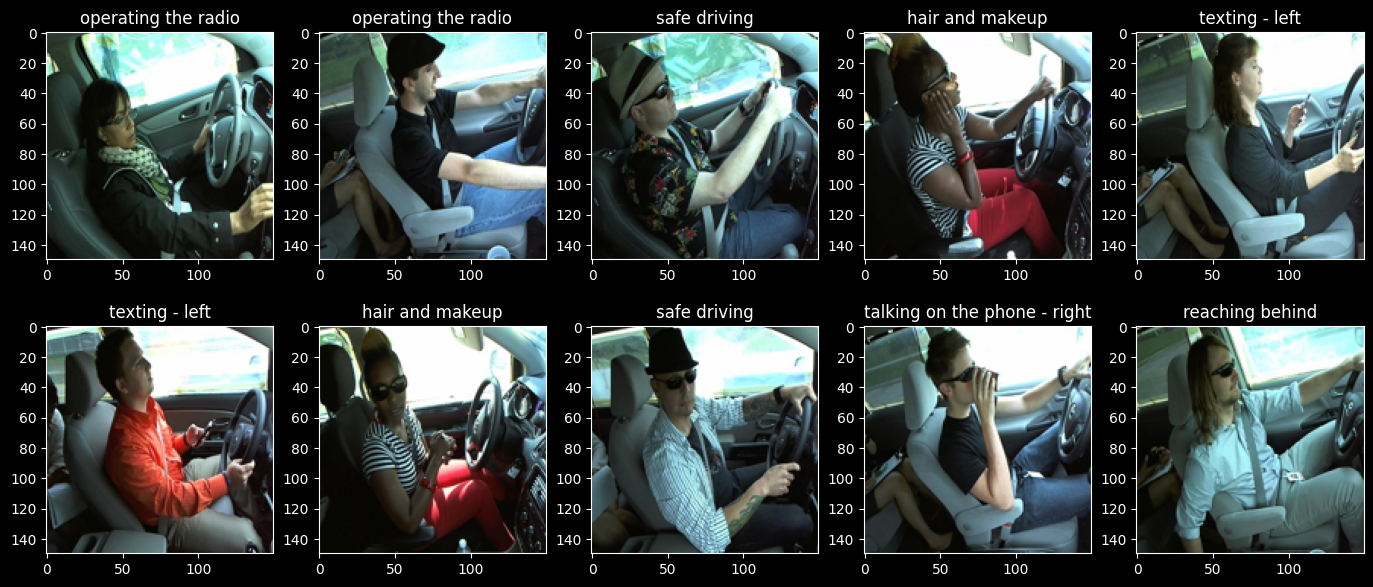

In [71]:
import random

plt.figure(figsize=(17, 7))

for i in range(0, 10, 1):
#     ind = random.randint(0, 8)
    plt.subplot(2, 5, i+1)
    plt.imshow(x[i])
    plt.title(tags[np.argmax(Predict[i])])

In [72]:
# Predict[0]
np.argmax(Predict[0])

5

In [73]:
sample_sub = pd.read_csv("/content/sample_submission.csv")
sample_sub.head()

img   c0   c1   c2   c3   c4   c5   c6   c7   c8   c9
0       img_1.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
1      img_10.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
2     img_100.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
3    img_1000.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
4  img_100000.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1

In [74]:
img = pd.DataFrame(img_names, columns = ['img'])
img.head(20)

img
0        img_1.jpg
1       img_10.jpg
2      img_100.jpg
3     img_1000.jpg
4   img_100000.jpg
5   img_100001.jpg
6   img_100002.jpg
7   img_100003.jpg
8   img_100004.jpg
9   img_100005.jpg
10  img_100007.jpg
11  img_100008.jpg
12  img_100009.jpg
13   img_10001.jpg
14  img_100010.jpg
15  img_100011.jpg
16  img_100012.jpg
17  img_100013.jpg
18  img_100014.jpg
19  img_100016.jpg

In [75]:
Pred = pd.DataFrame(Predict, columns = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9',])
Ans = pd.DataFrame({

    'Class': np.argmax(Predict, axis=1)

})
Pred.head()

c0            c1            c2            c3            c4  \
0  4.992622e-27  2.078092e-20  4.255209e-21  4.870111e-26  1.236621e-16   
1  3.130871e-12  1.495393e-07  3.720483e-09  1.080573e-11  8.214432e-10   
2  9.995924e-01  6.266417e-07  6.409152e-05  7.396880e-07  1.447107e-05   
3  2.509162e-22  4.419729e-26  4.937078e-18  4.922567e-15  1.894463e-14   
4  5.133486e-12  2.512930e-10  1.112192e-09  9.999878e-01  2.711198e-06   

             c5            c6            c7            c8            c9  
0  1.000000e+00  4.749485e-24  7.452400e-25  2.396914e-18  1.112412e-19  
1  9.999999e-01  1.411823e-10  3.566573e-10  3.328107e-08  1.634187e-09  
2  8.267271e-07  2.925692e-05  2.478403e-07  8.709390e-07  2.965524e-04  
3  1.258901e-17  4.525081e-16  5.338632e-21  1.000000e+00  1.563157e-17  
4  1.377783e-08  6.434940e-09  7.027319e-06  2.333013e-06  2.419122e-08

In [76]:
sub = pd.concat((img, Pred, Ans), axis = 1)
sub.head()

img            c0            c1            c2            c3  \
0       img_1.jpg  4.992622e-27  2.078092e-20  4.255209e-21  4.870111e-26   
1      img_10.jpg  3.130871e-12  1.495393e-07  3.720483e-09  1.080573e-11   
2     img_100.jpg  9.995924e-01  6.266417e-07  6.409152e-05  7.396880e-07   
3    img_1000.jpg  2.509162e-22  4.419729e-26  4.937078e-18  4.922567e-15   
4  img_100000.jpg  5.133486e-12  2.512930e-10  1.112192e-09  9.999878e-01   

             c4            c5            c6            c7            c8  \
0  1.236621e-16  1.000000e+00  4.749485e-24  7.452400e-25  2.396914e-18   
1  8.214432e-10  9.999999e-01  1.411823e-10  3.566573e-10  3.328107e-08   
2  1.447107e-05  8.267271e-07  2.925692e-05  2.478403e-07  8.709390e-07   
3  1.894463e-14  1.258901e-17  4.525081e-16  5.338632e-21  1.000000e+00   
4  2.711198e-06  1.377783e-08  6.434940e-09  7.027319e-06  2.333013e-06   

             c9  Class  
0  1.112412e-19      5  
1  1.634187e-09      5  
2  2.965524e-04      0  
3  1.563157e-17      8  
4  2.419122e-08      3

In [77]:
sub.columns

Index(['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9',
       'Class'],
      dtype='object')

In [78]:
sub[['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'Class']].to_csv(r'/content/sub256.csv', index=False)

# 11. <a name="11">**Group names**</a>

## 1. Andrew Abd El-Messih Fakhry
## 2. Asmaa Mohammed Mansour
## 3. Farah Yousri Abdel meguid
## 4. Marwan Sadek Abdo
## 5. Zyad Samy Ahmed